# imports

In [ ]:
#%pip install dotenv tensorflow==2.15.0 tensorflow-privacy==0.9.0
#%pip install wandb lakefs pathlib 

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\river\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
#%pip install seaborn matplotlib pandas numpy scikit-learn xgboost

[notice] A new release of pip is available: 24.0 -> 25.2


[notice] To update, run: C:\Users\river\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 325.1 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 744.7 kB/s eta 0:00:01
   ---------------------------------- ----- 256.0/294.9 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.7 MB/s eta 0:00:00
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tensorflow-privacy==0.9.0

  Using cached tensorflow_privacy-0.9.0-py3-none-any.whl.metadata (763 bytes)
Using cached tensorflow_privacy-0.9.0-py3-none-any.whl (323 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\river\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import wandb
import lakefs
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement
from tensorflow_privacy import DPKerasSGDOptimizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

C:\Users\river\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\river\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 

# Tool1 - lakefs

### Check current directory

In [2]:
print(f"Current directory: {os.getcwd()}")
print(f".env exists: {Path('.env').exists()}")
load_dotenv()

Current directory: c:\Users\river\OneDrive\Documents\Data Science\Masters Science - DS\5th Quarter\MLOPS\Assignments\Assign_1
.env exists: True


True

In [3]:
data_v1 = pd.read_csv('athletes.csv')
print(f"v1 shape: {data_v1.shape}")
print(data_v1.head())

v1 shape: (423006, 27)
   athlete_id           name               region          team  \
0      2554.0      Pj Ablang           South West   Double Edge   
1      3517.0  Derek Abdella                  NaN           NaN   
2      4691.0            NaN                  NaN           NaN   
3      5164.0    Abo Brandon  Southern California  LAX CrossFit   
4      5286.0    Bryce Abbey                  NaN           NaN   

              affiliate gender   age  height  weight   fran  ...  snatch  \
0  Double Edge CrossFit   Male  24.0    70.0   166.0    NaN  ...     NaN   
1                   NaN   Male  42.0    70.0   190.0    NaN  ...     NaN   
2                   NaN    NaN   NaN     NaN     NaN    NaN  ...     NaN   
3          LAX CrossFit   Male  40.0    67.0     NaN  211.0  ...   200.0   
4                   NaN   Male  32.0    65.0   149.0  206.0  ...   150.0   

   deadlift  backsq  pullups  \
0     400.0   305.0      NaN   
1       NaN     NaN      NaN   
2       NaN     NaN  

In [8]:
# Initialize client
client = lakefs.Client(
    host=os.getenv('LAKEFS_ENDPOINT'),
    username=os.getenv('LAKEFS_ACCESS_KEY'),
    password=os.getenv('LAKEFS_SECRET_KEY')
)

# Get or create repository
repo_name = "athletes-data-assign1-srivera"

# For cloud, use the storage namespace from your LakeFS cloud setup
repo = lakefs.Repository(repo_name, client=client).create(
    storage_namespace=f"s3://lakefs-sample-us-east-1-production/AROA5OU4KHZHHFCX4PTOM:ffae97af0adb7b31e0f7f5393d3fec7a6397e4000240d0304cb91c2e1beaa69d/1779//{repo_name}"
)
print(f"Repository '{repo_name}' created")

Repository 'athletes-data-assign1-srivera' created


## V1 data lake fs version

In [9]:
# v1: Add total_lift
data_v1['total_lift'] = data_v1['deadlift'] + data_v1['candj'] + data_v1['snatch'] + data_v1['backsq']


In [10]:
# Save and upload v1 to LakeFS with total_lift
data_v1.to_csv('athletes_v1.csv', index=False)
with open('athletes_v1.csv', 'rb') as f:
    repo.branch("main").object("athletes_v1.csv").upload(data=f.read())
repo.branch("main").commit(message="Add v1 raw dataset with total_lift")
print("v1 registered to LakeFS main branch")

v1 registered to LakeFS main branch


In [11]:
# v1: Train/test split
X_v1 = data_v1[['age', 'weight', 'height', 'deadlift', 'candj', 'snatch', 'backsq']]
y_v1 = data_v1['total_lift']
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_v1, y_v1, test_size=0.2, random_state=42)
print(f"v1 - Train: {X_train_v1.shape}, Test: {X_test_v1.shape}")

v1 - Train: (338404, 7), Test: (84602, 7)


## V2 DATA VERSION

In [12]:
# v2: Clean data
data_v2 = data_v1.copy()

data_v2 = data_v2.dropna(subset=['region','age','weight','height','howlong','gender','eat',
                        'train','background','experience','schedule','howlong',
                        'deadlift','candj','snatch','backsq','experience',
                        'background','schedule','howlong'])
data_v2 = data_v2.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',
                        'filthy50','fgonebad','run400','run5k','pullups','train'])

data_v2 = data_v2[data_v2['weight'] < 1500]
data_v2 = data_v2[data_v2['gender'] != '--']
data_v2 = data_v2[data_v2['age'] >= 18]
data_v2 = data_v2[(data_v2['height'] < 96) & (data_v2['height'] > 48)]

data_v2 = data_v2[(data_v2['deadlift'] > 0) & (data_v2['deadlift'] <= 1105)|((data_v2['gender'] == 'Female')
            & (data_v2['deadlift'] <= 636))]
data_v2 = data_v2[(data_v2['candj'] > 0) & (data_v2['candj'] <= 395)]
data_v2 = data_v2[(data_v2['snatch'] > 0) & (data_v2['snatch'] <= 496)]
data_v2 = data_v2[(data_v2['backsq'] > 0) & (data_v2['backsq'] <= 1069)]

decline_dict = {'Decline to answer|': np.nan}
data_v2 = data_v2.replace(decline_dict)
data_v2 = data_v2.dropna(subset=['background','experience','schedule','howlong','eat'])

# v2: Add total_lift
data_v2['total_lift'] = data_v2['deadlift'] + data_v2['candj'] + data_v2['snatch'] + data_v2['backsq']

In [13]:
# Save and upload v2 to LakeFS
data_v2.to_csv('athletes_v2.csv', index=False)
repo.branch("v2").create(source_reference="main")
with open('athletes_v2.csv', 'rb') as f:
    repo.branch("v2").object("athletes_v2.csv").upload(data=f.read())
repo.branch("v2").commit(message="Add v2 cleaned dataset with total_lift")
print("v2 registered to LakeFS v2 branch")


v2 registered to LakeFS v2 branch


In [6]:
# v2: Train/test split
X_v2 = data_v2[['age', 'weight', 'height', 'deadlift', 'candj', 'snatch', 'backsq']]
y_v2 = data_v2['total_lift']
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)
print(f"v2 - Train: {X_train_v2.shape}, Test: {X_test_v2.shape}")

v2 - Train: (24023, 7), Test: (6006, 7)


# EDA V1

=== V1 Dataset Statistics ===
          athlete_id            age        height         weight  \
count  423003.000000  331110.000000  1.598690e+05  229890.000000   
mean   292748.166538      32.516750  1.206217e+02     170.896137   
std    184969.660327       7.730671  2.097995e+04      58.379799   
min        82.000000      13.000000  0.000000e+00       1.000000   
25%    135091.500000      27.000000  6.600000e+01     145.000000   
50%    275839.000000      31.000000  6.900000e+01     170.000000   
75%    473188.000000      37.000000  7.200000e+01     192.000000   
max    633083.000000     125.000000  8.388607e+06   20175.000000   

               fran         helen         grace      filthy50      fgonebad  \
count  5.542600e+04  3.027900e+04  4.074500e+04  1.935900e+04  2.973800e+04   
mean   9.886691e+02  1.207950e+03  5.766025e+02  2.127863e+03  1.472252e+03   
std    7.200430e+04  6.824091e+04  4.891145e+04  6.055021e+04  9.762688e+04   
min    1.000000e+00  1.000000e+00 -6.0000

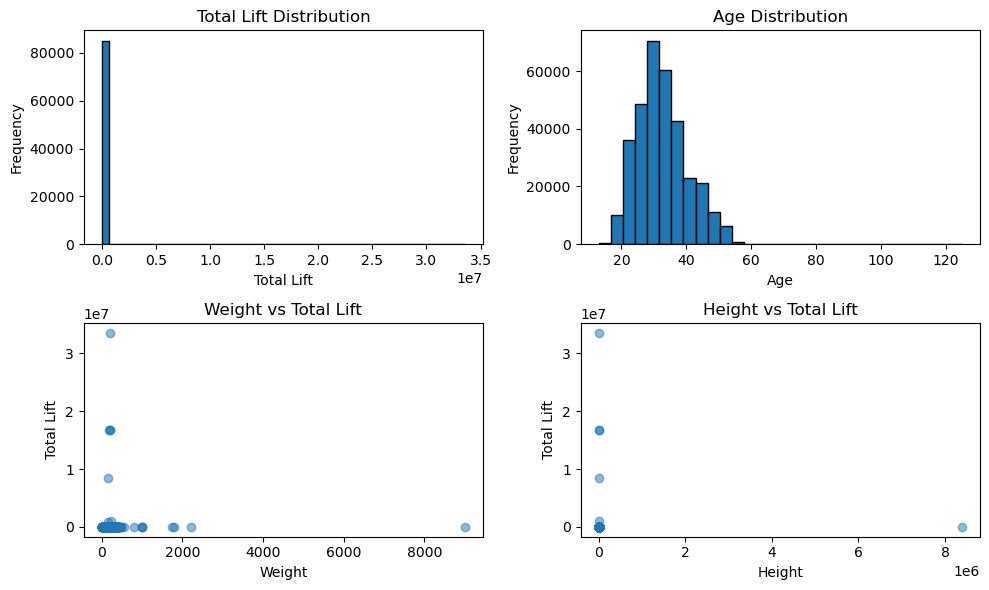

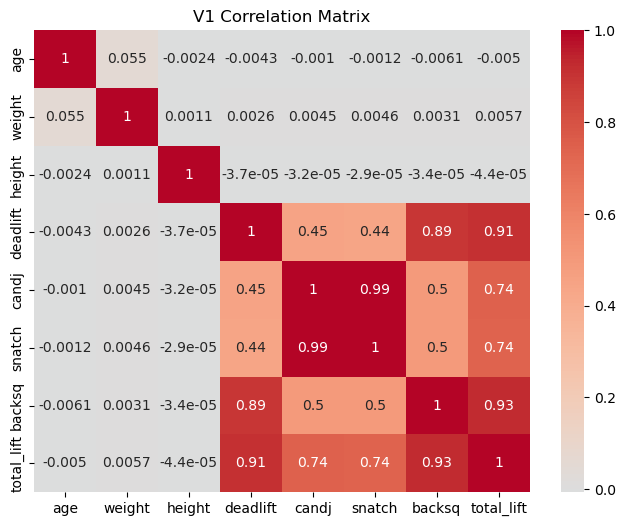

In [ ]:
# Basic statistics
print("=== V1 Dataset Statistics ===")
print(data_v1.describe())
print(f"\nShape: {data_v1.shape}")
print(f"\nMissing values:\n{data_v1.isnull().sum()}")

# Distribution of total_lift
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.hist(data_v1['total_lift'], bins=50, edgecolor='black')
plt.title('Total Lift Distribution')
plt.xlabel('Total Lift')
plt.ylabel('Frequency')

# Age distribution
plt.subplot(2, 2, 2)
plt.hist(data_v1['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Weight vs Total Lift
plt.subplot(2, 2, 3)
plt.scatter(data_v1['weight'], data_v1['total_lift'], alpha=0.5)
plt.title('Weight vs Total Lift')
plt.xlabel('Weight')
plt.ylabel('Total Lift')

# Height vs Total Lift
plt.subplot(2, 2, 4)
plt.scatter(data_v1['height'], data_v1['total_lift'], alpha=0.5)
plt.title('Height vs Total Lift')
plt.xlabel('Height')
plt.ylabel('Total Lift')

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
corr = data_v1[['age', 'weight', 'height', 'deadlift', 'candj', 'snatch', 'backsq', 'total_lift']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('V1 Correlation Matrix')
plt.show()

# LakeFS Model v1 data

In [14]:
# Load v1 from LakeFS
v1_obj = repo.branch("main").object("athletes_v1.csv")
v1_content = v1_obj.reader(mode='r').read()
from io import StringIO
data_v1_lakefs = pd.read_csv(StringIO(v1_content))

# Prepare data from LakeFS version
X_v1 = data_v1_lakefs[['age', 'weight', 'height', 'deadlift', 'candj', 'snatch', 'backsq']]
y_v1 = data_v1_lakefs['total_lift']
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_v1, y_v1, test_size=0.2, random_state=42)

# Drop NaNs from X and y
X_train_v1_clean = X_train_v1.dropna()
y_train_v1_clean = y_train_v1.loc[X_train_v1_clean.index]

X_test_v1_clean = X_test_v1.dropna()
y_test_v1_clean = y_test_v1.loc[X_test_v1_clean.index]

# Train XGBoost model
model_v1 = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model_v1.fit(X_train_v1_clean, y_train_v1_clean)

# Predictions
y_pred_v1 = model_v1.predict(X_test_v1_clean)

# Metrics
mse_v1 = mean_squared_error(y_test_v1_clean, y_pred_v1)
rmse_v1 = np.sqrt(mse_v1)
mae_v1 = mean_absolute_error(y_test_v1_clean, y_pred_v1)
r2_v1 = r2_score(y_test_v1_clean, y_pred_v1)

print("=== V1 Model Metrics ===")
print(f"RMSE: {rmse_v1:.2f}")
print(f"MAE: {mae_v1:.2f}")
print(f"R²: {r2_v1:.4f}")

=== V1 Model Metrics ===
RMSE: 153923.75
MAE: 1707.29
R²: 0.7608


# EDA V2

=== V2 Dataset Statistics ===
                age        height        weight         candj        snatch  \
count  30029.000000  30029.000000  30029.000000  30029.000000  30029.000000   
mean      32.123847     68.871924    177.130607    205.418396    156.174198   
std        7.435425      3.774937     32.399828     58.687508     48.833572   
min       18.000000     52.000000      5.000000      1.000000      1.000000   
25%       27.000000     66.000000    155.000000    160.000000    120.000000   
50%       31.000000     69.000000    178.000000    205.000000    155.000000   
75%       37.000000     72.000000    197.000000    245.000000    190.000000   
max       56.000000     83.000000    474.000000    390.000000    386.000000   

           deadlift        backsq    total_lift  
count  30029.000000  30029.000000  30029.000000  
mean     361.933997    294.118818   1017.645409  
std       96.745441     85.081340    277.682895  
min        0.000000      1.000000      4.000000  
25%     

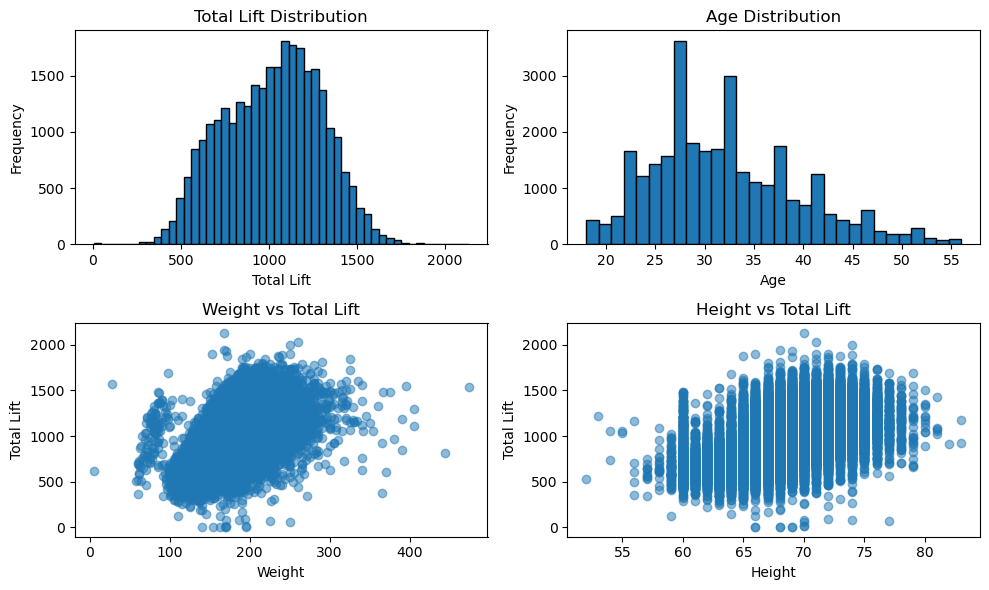

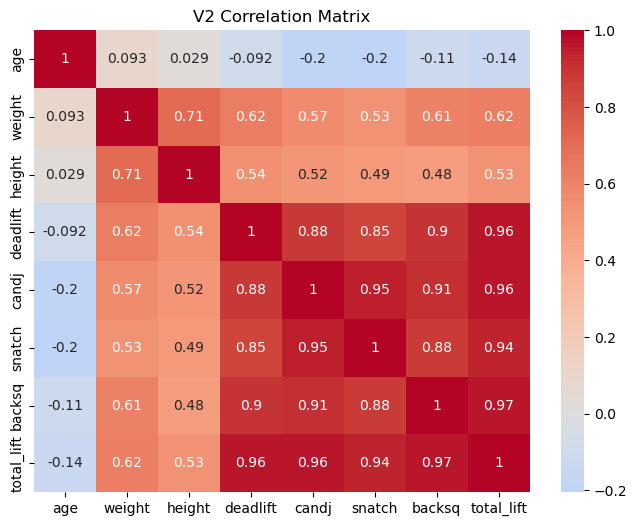

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
print("=== V2 Dataset Statistics ===")
print(data_v2.describe())
print(f"\nShape: {data_v2.shape}")
print(f"\nMissing values:\n{data_v2.isnull().sum()}")

# Distribution of total_lift
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.hist(data_v2['total_lift'], bins=50, edgecolor='black')
plt.title('Total Lift Distribution')
plt.xlabel('Total Lift')
plt.ylabel('Frequency')

# Age distribution
plt.subplot(2, 2, 2)
plt.hist(data_v2['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Weight vs Total Lift
plt.subplot(2, 2, 3)
plt.scatter(data_v2['weight'], data_v2['total_lift'], alpha=0.5)
plt.title('Weight vs Total Lift')
plt.xlabel('Weight')
plt.ylabel('Total Lift')

# Height vs Total Lift
plt.subplot(2, 2, 4)
plt.scatter(data_v2['height'], data_v2['total_lift'], alpha=0.5)
plt.title('Height vs Total Lift')
plt.xlabel('Height')
plt.ylabel('Total Lift')

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
corr = data_v2[['age', 'weight', 'height', 'deadlift', 'candj', 'snatch', 'backsq', 'total_lift']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('V2 Correlation Matrix')
plt.show()

# Lakefs Model v2 data

In [15]:
# Load v2 from LakeFS - demonstrating version switching
v2_obj = repo.branch("v2").object("athletes_v2.csv")
v2_content = v2_obj.reader(mode='r').read()
from io import StringIO
data_v2_lakefs = pd.read_csv(StringIO(v2_content))

# Prepare data from LakeFS v2
X_v2 = data_v2_lakefs[['age', 'weight', 'height', 'deadlift', 'candj', 'snatch', 'backsq']]
y_v2 = data_v2_lakefs['total_lift']
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# Use v2 data with SAME training code
X_train_v2_clean = X_train_v2.dropna()
y_train_v2_clean = y_train_v2.loc[X_train_v2_clean.index]

X_test_v2_clean = X_test_v2.dropna()
y_test_v2_clean = y_test_v2.loc[X_test_v2_clean.index]


In [16]:
# Train model (SAME CODE as v1)
model_v2 = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model_v2.fit(X_train_v2_clean, y_train_v2_clean)

# Predictions
y_pred_v2 = model_v2.predict(X_test_v2_clean)


### 11. Run metrics for this data v2 model.


In [24]:

# Metrics
mse_v2 = mean_squared_error(y_test_v2_clean, y_pred_v2)
rmse_v2 = np.sqrt(mse_v2)
mae_v2 = mean_absolute_error(y_test_v2_clean, y_pred_v2)
r2_v2 = r2_score(y_test_v2_clean, y_pred_v2)

print("=== V2 Model Metrics ===")
print(f"RMSE: {rmse_v2:.2f}")
print(f"MAE: {mae_v2:.2f}")
print(f"R²: {r2_v2:.4f}")

=== V2 Model Metrics ===
RMSE: 9.71
MAE: 5.58
R²: 0.9988


# 12. Compare and comment on the accuracy/metrics of the models using v1 and v2.

=== V1 Model Metrics ===
RMSE: 153923.75
MAE: 1707.29
R²: 0.7608

=== V2 Model Metrics ===
RMSE: 9.71
MAE: 5.58
R²: 0.9988


The same xgboost model is much more accurate with v2 data which is cleaned and has anomalies removed, validating the importance of robust data versioning and preprocessing pipelines in production ML system. 

The extreme RMSE in v1 (153k) suggests the presence of data entry errors or extreme outliers that were successfully removed in v2's cleaning process

In terms of performance we see RMSE and MAE are much lower indicating close fitting and that we utilized all maximum predictive power given the data. 

Removing invalid entries (e.g., gender='--', unrealistic lift values) and handling missing data improved feature signal-to-noise ratio

The low MAE (5.58 lbs) in v2 means predictions are highly accurate, with minimal average error.

# Lakefs DP w v2

Use tensor flow privacy library with the dataset v2 and calculate the metrics for the new DP model.


In [ ]:
#!pip install tensorflow==2.15.0 tensorflow-privacy==0.9.0

In [ ]:


# Scale features only
scaler = StandardScaler()
X_train_v2_scaled = scaler.fit_transform(X_train_v2_clean)
X_test_v2_scaled = scaler.transform(X_test_v2_clean)

# Build DP model
dp_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_v2_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# DP parameters
l2_norm_clip = 1.0
noise_multiplier = 3.0
batch_size = 256
epochs = 100
num_microbatches = 1
learning_rate = 0.25


optimizer = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.01
)

loss = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.NONE)
dp_model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

# Train DP model
history = dp_model.fit(
    X_train_v2_scaled, y_train_v2_clean,
    epochs=epochs,
    validation_data=(X_test_v2_scaled, y_test_v2_clean),
    batch_size=batch_size,
    verbose=1
)

# Compute DP guarantees
privacy_statement = compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_v2_clean),
    batch_size=batch_size,
    num_epochs=epochs,
    noise_multiplier=noise_multiplier,
    delta=1e-5,
    used_microbatching=True,
    max_examples_per_user=1
)

print("\n" + privacy_statement)

# Predictions
y_pred_dp = dp_model.predict(X_test_v2_scaled).flatten()

mse_dp = mean_squared_error(y_test_v2_clean, y_pred_dp)
rmse_dp = np.sqrt(mse_dp)
mae_dp = mean_absolute_error(y_test_v2_clean, y_pred_dp)
r2_dp = r2_score(y_test_v2_clean, y_pred_dp)

print("\n=== DP Model Metrics ===")
print(f"RMSE: {rmse_dp:.2f}")
print(f"MAE: {mae_dp:.2f}")
print(f"R²: {r2_dp:.4f}")

Epoch 1/100
94/94 [==============================] - 1s 3ms/step - loss: 1102164.2500 - mae: 1012.5169 - val_loss: 1074405.2500 - val_mae: 999.7993
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 1022927.6875 - mae: 975.5627 - val_loss: 960821.3125 - val_mae: 946.7983
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 881881.3750 - mae: 897.7495 - val_loss: 781762.5000 - val_mae: 840.3143
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 707173.3125 - mae: 804.5942 - val_loss: 591583.8125 - val_mae: 732.6992
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 491357.5000 - mae: 668.9941 - val_loss: 416788.7188 - val_mae: 621.1306
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 264843.9375 - mae: 470.7457 - val_loss: 92674.8281 - val_mae: 259.7242
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 83335.8750 - mae: 238.4938 - val_loss: 72662.2344 - va

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        52.579
    Epsilon assuming Poisson sampling (*):                      3.588

User-level DP with add-or-remove-one adjacency at delta = 1e-05 computed using
RDP accounting and group privacy:
    Epsilon with each example occurring once per epoch:        52.579
    Epsilon assuming Poisson sampling (*):                      3.588

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.

=== DP Model Metrics ===
RMSE: 2715.96
MAE: 2155.36
R²: -95.0362

# Tool 2 - W and Biases (W &B) 

## intialize and save v1

In [ ]:

# Initialize W&B project
wandb.login()

run = wandb.init(
    project="athletes-mlops",
    name="wandb-versioning",
    job_type="data-versioning"
)

# Create and log v1 artifact
artifact_v1 = wandb.Artifact(
    name='athletes-data-v1',
    type='dataset',
    description='Raw athletes dataset version 1'
)

# Save v1 to file and add to artifact
data_v1.to_csv('athletes_v1_wandb.csv', index=False)
artifact_v1.add_file('athletes_v1_wandb.csv')

# Log artifact
run.log_artifact(artifact_v1)

print("V1 dataset registered in W&B")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: riverase (riverase-safenet) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


V1 dataset registered in W&B


## save v2 to w&b

In [ ]:
# Create and log v2 artifact
artifact_v2 = wandb.Artifact(
    name='athletes-data-v2',
    type='dataset',
    description='Cleaned athletes dataset version 2'
)

# Add v2 file to artifact
artifact_v2.add_file('athletes_v2.csv')

# Log artifact
run.log_artifact(artifact_v2)

wandb.finish()

print("V2 dataset registered in W&B")

V2 dataset registered in W&B


# W&B Load v1 and train 

In [ ]:

#  Load v1 and train
run_v1 = wandb.init(project="athletes-mlops", name="wandb-v1-training", job_type="training")

# Load v1 from W&B
artifact_v1 = run_v1.use_artifact('athletes-data-v1:latest')
artifact_v1_dir = artifact_v1.download()
data_v1_wandb = pd.read_csv(f'{artifact_v1_dir}/athletes_v1_wandb.csv')

# Train model on v1 (same XGBoost code)


# Drop NaNs from X and y
X_train_v1_clean = X_train_v1.dropna()
y_train_v1_clean = y_train_v1.loc[X_train_v1_clean.index]

X_test_v1_clean = X_test_v1.dropna()
y_test_v1_clean = y_test_v1.loc[X_test_v1_clean.index]

# Train XGBoost model
model_v1 = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model_v1.fit(X_train_v1_clean, y_train_v1_clean)

# Predictions
y_pred_v1 = model_v1.predict(X_test_v1_clean)

# Metrics
mse_v1 = mean_squared_error(y_test_v1_clean, y_pred_v1)
rmse_v1 = np.sqrt(mse_v1)
mae_v1 = mean_absolute_error(y_test_v1_clean, y_pred_v1)
r2_v1 = r2_score(y_test_v1_clean, y_pred_v1)

print("=== V1 Model Metrics ===")
print(f"RMSE: {rmse_v1:.2f}")
print(f"MAE: {mae_v1:.2f}")
print(f"R²: {r2_v1:.4f}")

# Log metrics to W&B
wandb.log({"v1_rmse": rmse_v1, "v1_mae": mae_v1, "v1_r2": r2_v1})
wandb.finish()

wandb: Downloading large artifact 'athletes-data-v1:latest', 69.08MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.3 (221.4MB/s)


=== V1 Model Metrics ===
RMSE: 153923.75
MAE: 1707.29
R²: 0.7608


v1_mae,▁
v1_r2,▁
v1_rmse,▁
v1_mae,1707.2908
v1_r2,0.76084
v1_rmse,153923.75017


# W&B Load v2 and train

In [ ]:
run_v2 = wandb.init(project="athletes-mlops", name="wandb-v2-training", job_type="training")

X_train_v2_clean = X_train_v2.dropna()
y_train_v2_clean = y_train_v2.loc[X_train_v2_clean.index]

X_test_v2_clean = X_test_v2.dropna()
y_test_v2_clean = y_test_v2.loc[X_test_v2_clean.index]


# Load v2 from W&B (SAME CODE, just change version)
artifact_v2 = run_v2.use_artifact('athletes-data-v2:latest')
artifact_v2_dir = artifact_v2.download()
data_v2_wandb = pd.read_csv(f'{artifact_v2_dir}/athletes_v2.csv')

# Train model on v2 (SAME CODE)

# Train model (SAME CODE as v1)
model_v2 = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model_v2.fit(X_train_v2_clean, y_train_v2_clean)

# Predictions
y_pred_v2 = model_v2.predict(X_test_v2_clean)

# Metrics
mse_v2 = mean_squared_error(y_test_v2_clean, y_pred_v2)
rmse_v2 = np.sqrt(mse_v2)
mae_v2 = mean_absolute_error(y_test_v2_clean, y_pred_v2)
r2_v2 = r2_score(y_test_v2_clean, y_pred_v2)

print("=== V2 Model Metrics ===")
print(f"RMSE: {rmse_v2:.2f}")
print(f"MAE: {mae_v2:.2f}")
print(f"R²: {r2_v2:.4f}")
wandb.log({"v2_rmse": rmse_v2, "v2_mae": mae_v2, "v2_r2": r2_v2})
wandb.finish()

wandb:   1 of 1 files downloaded.  


=== V2 Model Metrics ===
RMSE: 9.71
MAE: 5.58
R²: 0.9988


v2_mae,▁
v2_r2,▁
v2_rmse,▁
v2_mae,5.57652
v2_r2,0.99877
v2_rmse,9.71264


12. Compare and comment on the accuracy/metrics of the models WandB:

### === V1 Model Metrics ===
RMSE: 153923.75
MAE: 1707.29
R²: 0.7608

### === V2 Model Metrics ===
v2_mae	5.57652
v2_r2	0.99877
v2_rmse	9.71264


Results are similar to the LakeFS results which shows we did everything well in our dual implementation of tools. As expected the V2 model which is cleaned has significantly better performance. 

# Wandb DP with V2

In [4]:
# Initialize W&B run for DP training
run_dp = wandb.init(
    project="athletes-mlops",
    name="wandb-v2-dp-training",
    job_type="dp-training"
)

# Load v2 from W&B
artifact_v2 = run_dp.use_artifact('athletes-data-v2:latest')
artifact_v2_dir = artifact_v2.download()
data_v2_wandb = pd.read_csv(f'{artifact_v2_dir}/athletes_v2.csv')

# Prepare data
X_v2 = data_v2_wandb[['age', 'weight', 'height', 'deadlift', 'candj', 'snatch', 'backsq']].dropna()
y_v2 = data_v2_wandb.loc[X_v2.index, 'total_lift'].dropna()

common_idx = X_v2.index.intersection(y_v2.index)
X_v2 = X_v2.loc[common_idx]
y_v2 = y_v2.loc[common_idx]

X_train, X_test, y_train, y_test = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build DP model
dp_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# DP parameters
l2_norm_clip = 1.0
noise_multiplier = 3.0
batch_size = 256
epochs = 100
num_microbatches = 1

# Log hyperparameters to W&B
wandb.config.update({
    "l2_norm_clip": l2_norm_clip,
    "noise_multiplier": noise_multiplier,
    "batch_size": batch_size,
    "epochs": epochs,
    "num_microbatches": num_microbatches
})

optimizer = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.01
)

loss = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.NONE)
dp_model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

# Train DP model
history = dp_model.fit(
    X_train_scaled, y_train,
    epochs=epochs,
    validation_data=(X_test_scaled, y_test),
    batch_size=batch_size,
    verbose=1
)

# Compute DP guarantees
privacy_statement = compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train),
    batch_size=batch_size,
    num_epochs=epochs,
    noise_multiplier=noise_multiplier,
    delta=1e-5,
    used_microbatching=True,
    max_examples_per_user=1
)

print("\n" + privacy_statement)

# Predictions and metrics
y_pred_dp = dp_model.predict(X_test_scaled).flatten()

mse_dp = mean_squared_error(y_test, y_pred_dp)
rmse_dp = np.sqrt(mse_dp)
mae_dp = mean_absolute_error(y_test, y_pred_dp)
r2_dp = r2_score(y_test, y_pred_dp)

print("\n=== W&B DP Model Metrics ===")
print(f"RMSE: {rmse_dp:.2f}")
print(f"MAE: {mae_dp:.2f}")
print(f"R²: {r2_dp:.4f}")

# Log metrics to W&B
wandb.log({
    "dp_rmse": rmse_dp,
    "dp_mae": mae_dp,
    "dp_r2": r2_dp,
    "epsilon": 3.588
})

wandb.finish()

wandb: Currently logged in as: riverase (riverase-safenet) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  



Epoch 1/100

94/94 [==============================] - 3s 7ms/step - loss: 1112003.6250 - mae: 1017.2817 - val_loss: 1098373.8750 - val_mae: 1010.7269
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 1086240.2500 - mae: 1003.4634 - val_loss: 1063972.0000 - val_mae: 992.3470
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 999603.3125 - mae: 956.0300 - val_loss: 903937.8125 - val_mae: 904.4727
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 784126.9375 - mae: 835.3790 - val_loss: 564272.6250 - val_mae: 707.8396
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 436708.1562 - mae: 610.5818 - val_loss: 298347.3438 - val_mae: 495.1417
Epoch 6/100
94/94 [==============================] - 1s 7ms/step - loss: 202689.5625 - mae: 392.3624 - val_loss: 153231.3438 - val_mae: 336.8829
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 135692.5156 - mae: 304.7881 - val_loss: 101017.9

dp_mae,▁
dp_r2,▁
dp_rmse,▁
epsilon,▁
dp_mae,1939.85172
dp_r2,-90.21087
dp_rmse,2646.84949
epsilon,3.588


# Compare and comment on the accuracy/metrics of the non-DP and DP models using dataset v2 - submit 1 slide

Non-DP XGBoost v2: 
mae = 5.576, 
r2  = 0.998
rmse = 9.712



In [6]:
print(f"DP Neural Network v2 (LakeFS): RMSE=2715.96, MAE=2155.36, R²=-95.04, ε=3.588")
print(f"DP Neural Network v2 (W&B): RMSE=2646.85, MAE=1939.85, R²=-90.21, ε=3.588")


DP Neural Network v2 (LakeFS): RMSE=2715.96, MAE=2155.36, R²=-95.04, ε=3.588
DP Neural Network v2 (W&B): RMSE=2646.85, MAE=1939.85, R²=-90.21, ε=3.588


## Conclusion: DP provides strong privacy guarantees (ε=3.588) but significantly reduces model utility due to gradient clipping and noise addition in DP-SGD.The privacy-utility tradeoff is substantial: R² drops from 0.9988 to approximately -90 to -95.